# PREP

In [31]:
import os
import numpy as np
import math
import pandas as pd
import re
from functools import reduce
from collections import OrderedDict
from itertools import chain
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    multilabel_confusion_matrix,
    ConfusionMatrixDisplay, 
    accuracy_score
)
from wildlifeml.utils.io import (
    load_csv, 
    load_json, 
    load_pickle,
)

## TODO remove old code and repetitions

In [32]:
REPODIR = '/home/lisa-wm/Documents/1_work/1_research/repos/wildlife-experiments'
RESULTDIR = os.path.join(REPODIR, 'results')
# REPODIR = '/home/wimmerl/projects/wildlife-experiments'

CFG = load_json(os.path.join(REPODIR, 'configs/cfg.json'))
LABEL_MAP = load_json(os.path.join(REPODIR, 'data/label_map.json'))
EMPTY_CLASS = LABEL_MAP['empty']
CONFMAT_ARGS = {
    'normalize': 'true',
    'values_format': '.2f',
    'display_labels': list(LABEL_MAP.keys()),
    'xticks_rotation': 'vertical',
    'colorbar': False,
    'cmap': 'Blues',
}
THRESHOLDS = [0.3, 0.5, 0.7, 0.9]
OUR_THRESH = 0.5
ITERATIONS = list(range(9))[1:]
RANDOM_SEEDS = ['123', '456', '789']

## DATA

In [33]:
FILES_INSAMPLE = [
    [os.path.join(RESULTDIR, t, f) for f in os.listdir(os.path.join(RESULTDIR, t)) if 'insample_test' in f] 
    for t in [str(int(100 * ts)) for ts in THRESHOLDS]
]
FILES_OOSAMPLE = [
    os.path.join(RESULTDIR, str(int(100 * OUR_THRESH)), f) 
    for f in os.listdir(os.path.join(RESULTDIR, str(int(100 * OUR_THRESH)))) 
    if 'oosample' in f 
]
FILES_ACTIVE_OPTIMAL = [
    os.path.join(RESULTDIR, f) for f in os.listdir(RESULTDIR) if 'active_optimal' in f 
]
FILES_ACTIVE_COLDSTART = [os.path.join(RESULTDIR, 'coldstart', 'entropy', rs) for rs in RANDOM_SEEDS]
FILES_ACTIVE_WARMSTART = [os.path.join(RESULTDIR, 'warmstart', 'entropy', rs) for rs in RANDOM_SEEDS]

In [34]:
# RESULT_FILE = {**RESULTS_INSAMPLE_TEST_01, **RESULTS_INSAMPLE_TEST_05}
PREDS = 'preds_imgs_ppl'
TRUTH = 'truth_imgs_ppl'

In [35]:
def sort_results(dict_preds, truth):
    ordered_dict = {k: dict_preds[k] for k in sorted(list(dict_preds.keys()))}
    ordered_array = np.concatenate([x.reshape(1, len(LABEL_MAP)) for x in list(ordered_dict.values())])
    ordered_list = [truth[k] for k in [list(dict_preds.keys()).index(i) for i in sorted(list(dict_preds.keys()))]]
    return ordered_array, ordered_list

# IN-SAMPLE

## PERFORMANCE ACROSS THRESHOLDS ON TEST

Using varying thresholds for the MD, how well is our pipeline able to 1) classify images overall, 2) detect empty images correctly?

In [28]:
rows_multiclass_avg, rows_multiclass_se = [], []
rows_empty_avg, rows_empty_se = [], []

for idx, t in enumerate(THRESHOLDS):
    results_t = [f for f in FILES_INSAMPLE[idx]]
    accs, precs, recs, fones = [], [], [], []
    accs_empty, precs_empty, recs_empty, fones_empty = [], [], [], []
    precs_nonempty, recs_nonempty, fones_nonempty = [], [], []
    for rt in results_t:
        r = load_pickle(rt)
        preds_imgs_ppl_t, truth_imgs_ppl_t = sort_results(r[PREDS], r[TRUTH])
        y_true = truth_imgs_ppl_t
        y_pred = [np.argmax(v) for v in preds_imgs_ppl_t]
        report = classification_report(
            y_true=y_true, 
            y_pred=y_pred,
            target_names=list(LABEL_MAP.keys()),
            zero_division=0,
            output_dict=True,
        )
        accs.append(report['accuracy'])
        precs.append(report['weighted avg']['precision'])
        recs.append(report['weighted avg']['recall'])
        fones.append(report['weighted avg']['f1-score'])
        conf_empty = multilabel_confusion_matrix(y_true, y_pred, labels=[EMPTY_CLASS])
        tn, fp, fn, tp = conf_empty.ravel()
        accs_empty.append((tn + tp) / (tn + fp + fn + tp))
        precs_empty.append(report['empty']['precision'])
        recs_empty.append(report['empty']['recall'])
        fones_empty.append(report['empty']['f1-score'])
        precs_nonempty.append(tn / (tn + fn))
        recs_nonempty.append(tn / (tn + fp))
        fones_nonempty.append(2 * tn / (2 * tn + fn + fp))
    accs = np.array(accs)
    precs = np.array(precs)
    recs = np.array(recs)
    fones = np.array(fones)
    rows_multiclass_avg.append([t, np.mean(accs), np.mean(precs), np.mean(recs), np.mean(fones)])
    rows_multiclass_se.append(
        [
            t,
            np.std(accs) / math.sqrt(len(accs)),
            np.std(precs) / math.sqrt(len(precs)),
            np.std(recs) / math.sqrt(len(recs)),
            np.std(fones) / math.sqrt(len(fones))
        ]
        
    )
    accs_empty = np.array(accs_empty)
    precs_empty = np.array(precs_empty)
    recs_empty = np.array(recs_empty)
    fones_empty = np.array(fones_empty)
    precs_nonempty = np.array(precs_nonempty)
    recs_nonempty = np.array(recs_nonempty)
    fones_nonempty = np.array(fones_nonempty)
    rows_empty_avg.append(
        [
            t, 
            np.mean(accs_empty), 
            np.mean(precs_empty), 
            np.mean(recs_empty), 
            np.mean(fones_empty),
            np.mean(precs_nonempty), 
            np.mean(recs_nonempty), 
            np.mean(fones_nonempty)
        ]
    )
    rows_empty_se.append(
        [
            t,
            np.std(accs_empty) / math.sqrt(len(accs_empty)),
            np.std(precs_empty) / math.sqrt(len(precs_empty)),
            np.std(recs_empty) / math.sqrt(len(recs_empty)),
            np.std(fones_empty) / math.sqrt(len(fones_empty)),
            np.std(precs_empty) / math.sqrt(len(precs_nonempty)),
            np.std(recs_empty) / math.sqrt(len(recs_nonempty)),
            np.std(fones_empty) / math.sqrt(len(fones_nonempty))
        ]
        
    )
COLNAMES = ['threshold', 'acc', 'prec', 'rec', 'fone']
COLNAMES_EMPTY = ['threshold', 'acc', 'prec', 'rec', 'fone', 'prec_ne', 'rec_ne', 'fone_ne']
df_ins_multiclass_avg = pd.DataFrame(rows_multiclass_avg, columns=COLNAMES)
df_ins_multiclass_se = pd.DataFrame(rows_multiclass_se, columns=COLNAMES)
df_ins_empty_avg = pd.DataFrame(rows_empty_avg, columns=COLNAMES_EMPTY)
df_ins_empty_se = pd.DataFrame(rows_empty_se, columns=COLNAMES_EMPTY)

In [7]:
df_ins_multiclass_avg  # Table 3

,threshold,acc,prec,rec,fone
0,0.3,0.926422,0.921628,0.926422,0.922216
1,0.5,0.924416,0.919696,0.924416,0.920191
2,0.7,0.928246,0.922879,0.928246,0.922998
3,0.9,0.922958,0.916711,0.922958,0.916285


In [29]:
df_ins_empty_avg  # Table 2

,threshold,acc,prec,rec,fone,prec_ne,rec_ne,fone_ne
0,0.3,0.952316,0.947133,0.980948,0.963743,0.962812,0.900052,0.930370
1,0.5,0.949489,0.942551,0.981654,0.961696,0.963896,0.890778,0.925859
2,0.7,0.952498,0.940072,0.989557,0.964179,0.978926,0.884853,0.929512
3,0.9,0.949034,0.934266,0.990827,0.961715,0.981185,0.872746,0.923791


In [9]:
df_ins_multiclass_se

,threshold,acc,prec,rec,fone
0,0.3,0.001686,0.002152,0.001686,0.001999
1,0.5,0.002778,0.002854,0.002778,0.002567
2,0.7,0.001391,0.001724,0.001391,0.001465
3,0.9,0.001112,0.001282,0.001112,0.001337


In [10]:
df_ins_empty_se

,threshold,acc,prec,rec,fone
0,0.3,0.000324,0.000421,0.000870,0.000265
1,0.5,0.002064,0.000976,0.003245,0.001619
2,0.7,0.000859,0.000337,0.001169,0.000663
3,0.9,0.000649,0.000537,0.000831,0.000493


## PERFORMANCE

In [11]:
def dict_mean(dict_list):
    mean_dict = {}
    list_k0 = list(dict_list[0].keys())
    accumulator0 = 0
    list_k1 = list(dict_list[0][list_k0[0]].keys())
    accumulator1 = [[0 for _ in list_k1] for _ in list_k0]
    for idx0 in range(len(dict_list)):
        for idx1, k0 in enumerate(list_k0):
            for idx2, k1 in enumerate(list_k1):
                if isinstance(dict_list[idx0][k0], dict):
                    accumulator1[idx1][idx2] += dict_list[idx0][k0][k1]
            if k0 == 'accuracy':
                accumulator0 += dict_list[idx0][k0]
            mean_dict.update(
                {
                    k0: {
                        k: accumulator1[idx1][idx] / len(dict_list) for idx, k in enumerate(list_k1) 
                        if k0 != 'accuracy'
                    }
                }
            )
            mean_dict.update({'accuracy': accumulator0 / len(dict_list)})
    return mean_dict

In [12]:
reports, conf_matrices = [], []
y_trues, y_preds = np.empty(0), np.empty(0)
for r in [load_pickle(f) for f in FILES_INSAMPLE[1]]:
    preds_imgs_ppl_t, truth_imgs_ppl_t = sort_results(r['preds_imgs_ppl'], r['truth_imgs_ppl'])
    y_trues = np.concatenate((y_trues, truth_imgs_ppl_t))
    y_preds = np.concatenate((y_preds, [np.argmax(v) for v in preds_imgs_ppl_t]))
print(  # Figure 3
    classification_report(
        y_true=np.array(y_trues), 
        y_pred=np.array(y_preds),
        target_names=list(LABEL_MAP.keys()),
    )
)

               precision    recall  f1-score   support

        empty       0.94      0.98      0.96      7086
european_hare       0.91      0.71      0.80       192
       others       0.55      0.39      0.46       432
     red_deer       1.00      0.67      0.80        21
      red_fox       0.87      0.71      0.78       297
 red_squirrel       0.92      0.81      0.86       141
     roe_deer       0.93      0.92      0.92      2712
    wild_boar       0.88      0.49      0.63        87

     accuracy                           0.92     10968
    macro avg       0.87      0.71      0.78     10968
 weighted avg       0.92      0.92      0.92     10968



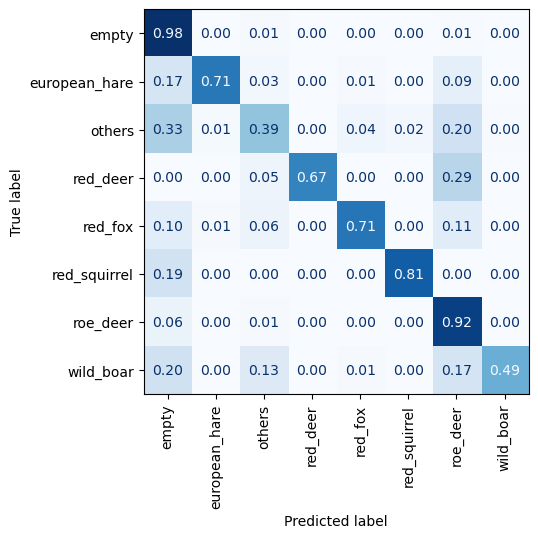

In [17]:
ConfusionMatrixDisplay.from_predictions(y_true=np.array(y_trues), y_pred=np.array(y_preds), **CONFMAT_ARGS)
# plt.gcf().set_size_inches(8, 9)
# plt.figure(figsize=(5, 6))
plt.rcParams["figure.figsize"] = (7, 7)
plt.savefig('cm_insample.eps')

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

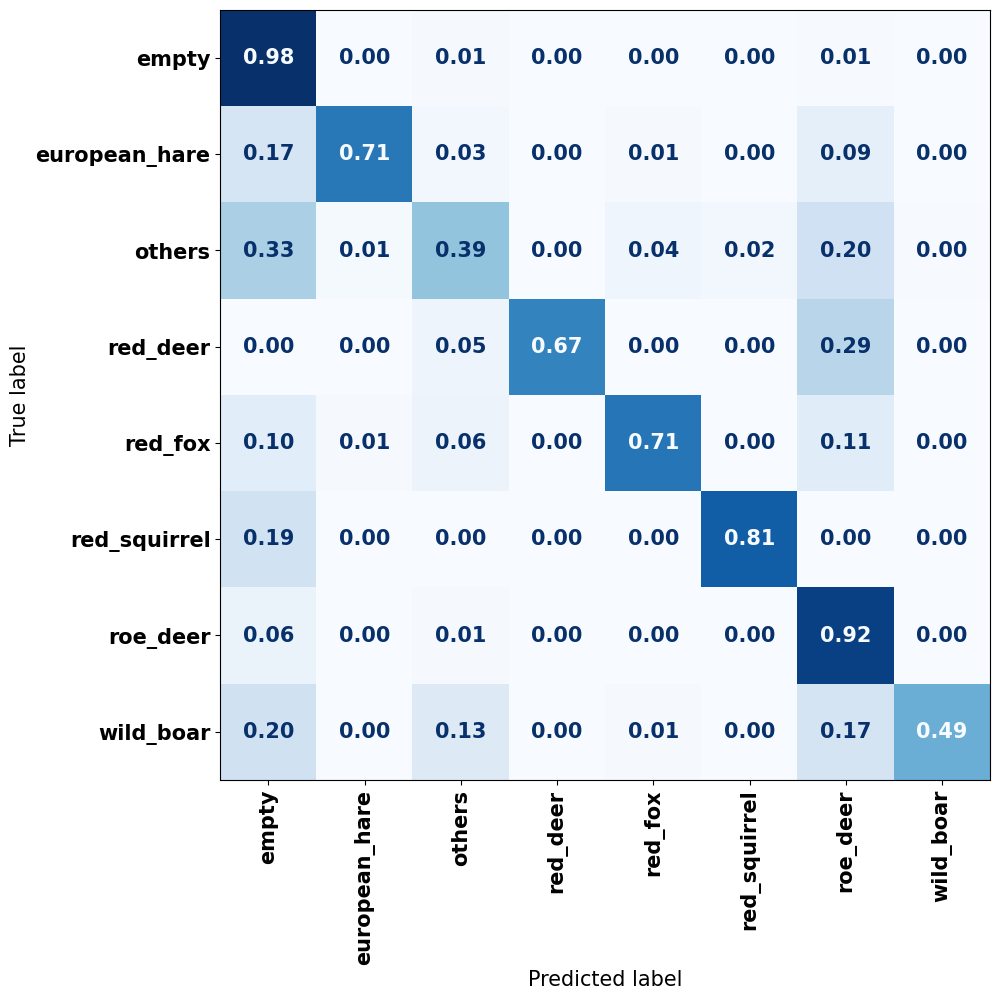

In [87]:
cmp = ConfusionMatrixDisplay.from_predictions(y_true=np.array(y_trues), y_pred=np.array(y_preds), **CONFMAT_ARGS)
fig = cmp.figure_
fig.set_figwidth(12)
fig.set_figheight(10) 
plt.savefig('cm_insample.eps')

# OUT-OF-SAMPLE

## PERFORMANCE

In [36]:
rows_multiclass_avg, rows_multiclass_se = [], []
accs, precs, recs, fones = [], [], [], []

for r in [f for f in FILES_OOSAMPLE]:
    r = load_pickle(r)
    preds_imgs_ppl, truth_imgs_ppl = sort_results(r[PREDS], r[TRUTH])
    y_true = truth_imgs_ppl
    y_pred = [np.argmax(v) for v in preds_imgs_ppl]
    report = classification_report(
        y_true=y_true, 
        y_pred=y_pred,
        target_names=list(LABEL_MAP.keys()),
        zero_division=0,
        output_dict=True,
    )
    accs.append(report['accuracy'])
    precs.append(report['weighted avg']['precision'])
    recs.append(report['weighted avg']['recall'])
    fones.append(report['weighted avg']['f1-score'])
accs = np.array(accs)
precs = np.array(precs)
recs = np.array(recs)
fones = np.array(fones)
rows_multiclass_avg.append([np.mean(accs), np.mean(precs), np.mean(recs), np.mean(fones)])
rows_multiclass_se.append(
    [
        np.std(accs) / math.sqrt(len(accs)),
        np.std(precs) / math.sqrt(len(precs)),
        np.std(recs) / math.sqrt(len(recs)),
        np.std(fones) / math.sqrt(len(fones))
    ]

)
COLNAMES = ['acc', 'prec', 'rec', 'fone']
df_oos_multiclass_avg = pd.DataFrame(rows_multiclass_avg, columns=COLNAMES)
df_oos_multiclass_se = pd.DataFrame(rows_multiclass_se, columns=COLNAMES)

In [37]:
acc_al_lower_limit, rec_al_lower_limit = rows_multiclass_avg[0][0], rows_multiclass_avg[0][1]

In [38]:
df_multiclass_avg = pd.concat(
    [df_ins_multiclass_avg.loc[df_ins_multiclass_avg['threshold'] == OUR_THRESH], df_oos_multiclass_avg]
)
df_multiclass_avg.index = ['ins', 'oos']

In [39]:
df_multiclass_se = pd.concat(
    [df_ins_multiclass_se.loc[df_ins_multiclass_se['threshold'] == OUR_THRESH], df_oos_multiclass_se]
)
df_multiclass_se.index = ['ins', 'oos']

In [40]:
df_multiclass_avg.drop(['threshold'], axis=1)  # Table 5

,acc,prec,rec,fone
ins,0.924416,0.919696,0.924416,0.920191
oos,0.880625,0.873927,0.880625,0.873361


In [41]:
df_multiclass_se.drop(['threshold'], axis=1)

,acc,prec,rec,fone
ins,0.002778,0.002854,0.002778,0.002567
oos,0.001010,0.001129,0.001010,0.001367


               precision    recall  f1-score   support

        empty       0.94      0.96      0.95      6414
european_hare       0.60      0.41      0.49       111
       others       0.35      0.23      0.27       477
     red_deer       1.00      0.03      0.05        36
      red_fox       0.28      0.59      0.38        51
 red_squirrel       0.14      0.67      0.23         6
     roe_deer       0.85      0.90      0.88      3126
    wild_boar       0.88      0.51      0.65       468

     accuracy                           0.88     10689
    macro avg       0.63      0.54      0.49     10689
 weighted avg       0.88      0.88      0.87     10689



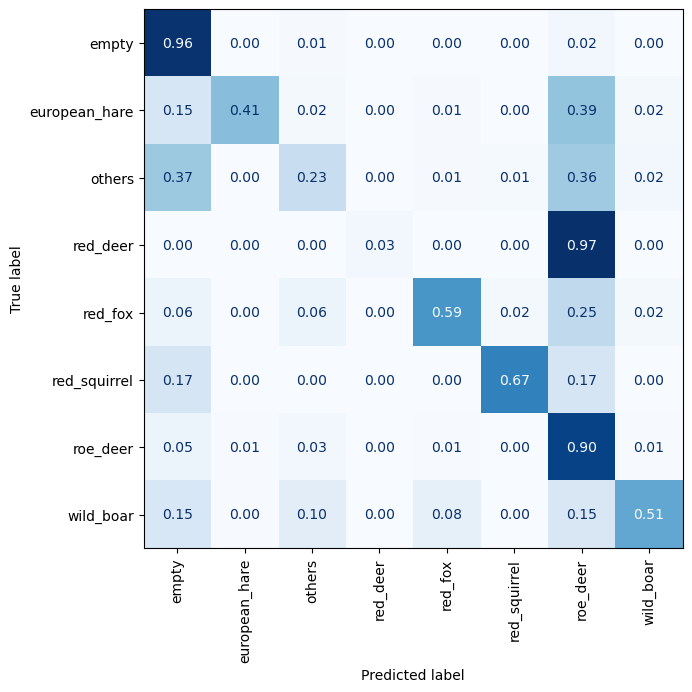

In [42]:
reports, conf_matrices = [], []
y_trues, y_preds = np.empty(0), np.empty(0)
for r in [load_pickle(f) for f in FILES_OOSAMPLE]:
    preds_imgs_ppl_t, truth_imgs_ppl_t = sort_results(r['preds_imgs_ppl'], r['truth_imgs_ppl'])
    y_trues = np.concatenate((y_trues, truth_imgs_ppl_t))
    y_preds = np.concatenate((y_preds, [np.argmax(v) for v in preds_imgs_ppl_t]))

print(  # Figure 5
    classification_report(
        y_true=np.array(y_trues), 
        y_pred=np.array(y_preds),
        target_names=list(LABEL_MAP.keys()),
        zero_division=0
    )

) 
ConfusionMatrixDisplay.from_predictions(y_true=np.array(y_trues), y_pred=np.array(y_preds), **CONFMAT_ARGS)

## ACTIVE LEARNING

In [43]:
reports, conf_matrices = [], []
y_trues, y_preds = np.empty(0), np.empty(0)
for r in [load_pickle(f) for f in FILES_ACTIVE_OPTIMAL]:
    preds_imgs_ppl_t, truth_imgs_ppl_t = sort_results(r['preds_imgs_ppl'], r['truth_imgs_ppl'])
    y_trues = np.concatenate((y_trues, truth_imgs_ppl_t))
    y_preds = np.concatenate((y_preds, [np.argmax(v) for v in preds_imgs_ppl_t]))
report_dict = classification_report(
    y_true=np.array(y_trues), 
    y_pred=np.array(y_preds),
    target_names=list(LABEL_MAP.keys()),
    output_dict=True,
    zero_division=0
)
acc_al_upper_limit, rec_al_upper_limit = report_dict['accuracy'], report_dict['weighted avg']['precision']

               precision    recall  f1-score   support

        empty       0.94      0.98      0.96      6414
european_hare       0.94      0.61      0.74       111
       others       0.76      0.37      0.50       477
     red_deer       0.74      0.47      0.58        36
      red_fox       0.86      0.73      0.79        51
 red_squirrel       0.83      0.83      0.83         6
     roe_deer       0.91      0.93      0.92      3126
    wild_boar       0.93      0.81      0.86       468

     accuracy                           0.93     10689
    macro avg       0.86      0.72      0.77     10689
 weighted avg       0.92      0.93      0.92     10689



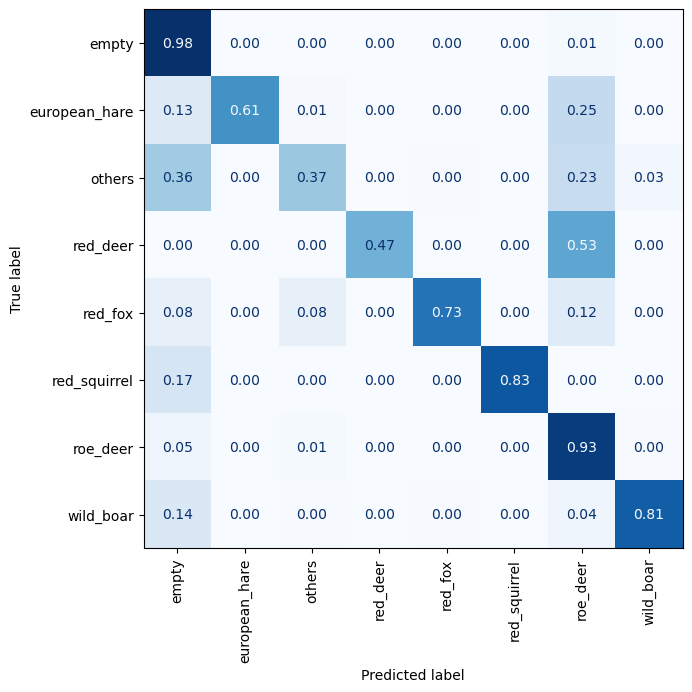

In [44]:
print(  # Figure 5
    classification_report(
        y_true=np.array(y_trues), 
        y_pred=np.array(y_preds),
        target_names=list(LABEL_MAP.keys()),
        zero_division=0
    )

) 
ConfusionMatrixDisplay.from_predictions(y_true=np.array(y_trues), y_pred=np.array(y_preds), **CONFMAT_ARGS)

In [45]:
# compute relative sample size per iteration (sizes hard-coded for training)
n_obs = 23491
init_batches = [2**x for x in range(7, 14)]
batch_sizes = init_batches + [n_obs - sum(init_batches)]
batch_sizes_cs = np.cumsum([x / n_obs for x in batch_sizes])

In [46]:
acc_coldstart_avg, rec_coldstart_avg = [], []
acc_coldstart_se, rec_coldstart_se = [], []
acc_warmstart_avg, rec_warmstart_avg = [], []
acc_warmstart_se, rec_warmstart_se = [], []

for i in ITERATIONS:
    acc_coldstart, rec_coldstart = [], []
    acc_warmstart, rec_warmstart = [], []
    for r in [
        load_pickle(f) for f in [
            os.path.join(FILES_ACTIVE_COLDSTART[idx], f'results_iteration_{i}.pkl') 
            for idx, _ in enumerate(RANDOM_SEEDS)
        ]
    ]:
        preds_imgs_ppl, truth_imgs_ppl = sort_results(r['preds_imgs_ppl'], r['truth_imgs_ppl'])
        y_true = truth_imgs_ppl
        y_pred = [np.argmax(v) for v in preds_imgs_ppl]
        report_dict_cs = classification_report(
            y_true=y_true, 
            y_pred=y_pred,
            target_names=list(LABEL_MAP.keys()),
            output_dict=True,
            zero_division=0
        )
        acc_coldstart.append(report_dict_cs['accuracy'])
        rec_coldstart.append(report_dict_cs['weighted avg']['precision'])
    for r in [
        load_pickle(f) for f in [
            os.path.join(FILES_ACTIVE_WARMSTART[idx], f'results_iteration_{i}.pkl') 
            for idx, _ in enumerate(RANDOM_SEEDS) # !!!!
        ]
    ]:
        preds_imgs_ppl, truth_imgs_ppl = sort_results(r['preds_imgs_ppl'], r['truth_imgs_ppl'])
        y_true = truth_imgs_ppl
        y_pred = [np.argmax(v) for v in preds_imgs_ppl]
        report_dict_ws = classification_report(
            y_true=y_true, 
            y_pred=y_pred,
            target_names=list(LABEL_MAP.keys()),
            output_dict=True,
            zero_division=0
        )
        acc_warmstart.append(report_dict_ws['accuracy'])
        rec_warmstart.append(report_dict_ws['weighted avg']['precision'])
    acc_coldstart = np.array(acc_coldstart)
    rec_coldstart = np.array(rec_coldstart)
    acc_coldstart_avg.append(np.mean(acc_coldstart))
    rec_coldstart_avg.append(np.mean(rec_coldstart))
    acc_coldstart_se.append(np.std(acc_coldstart) / math.sqrt(len(acc_coldstart)))
    rec_coldstart_se.append(np.std(rec_coldstart) / math.sqrt(len(rec_coldstart)))
    acc_warmstart = np.array(acc_warmstart)
    rec_coldstart = np.array(rec_warmstart)
    acc_warmstart_avg.append(np.mean(acc_warmstart))
    rec_warmstart_avg.append(np.mean(rec_warmstart))
    acc_warmstart_se.append(np.std(acc_warmstart) / math.sqrt(len(acc_warmstart)))
    rec_warmstart_se.append(np.std(rec_warmstart) / math.sqrt(len(rec_warmstart)))

In [47]:
acc_coldstart_avg[-1] = acc_al_upper_limit
rec_coldstart_avg[-1] = rec_al_upper_limit
acc_warmstart_avg[-1] = acc_al_upper_limit
rec_warmstart_avg[-1] = rec_al_upper_limit

In [48]:
# create data for plot
al_perf_acc = {
    'relative_size': batch_sizes_cs,
    'acc_lower_limit': [acc_al_lower_limit for _ in range(len(acc_coldstart_avg))],
    'acc_upper_limit': [acc_al_upper_limit for _ in range(len(acc_coldstart_avg))],
    'acc_coldstart': acc_coldstart_avg,
    'se_coldstart': acc_coldstart_se,
    'acc_warmstart': acc_warmstart_avg,
    'se_warmstart': acc_warmstart_se,
}
al_perf_rec = {
    'relative_size': batch_sizes_cs,
    'rec_lower_limit': [rec_al_lower_limit for _ in range(len(acc_coldstart_avg))],
    'rec_upper_limit': [rec_al_upper_limit for _ in range(len(acc_coldstart_avg))],
    'rec_coldstart': rec_coldstart_avg,
    'rec_coldstart_se': rec_coldstart_se,
#     'rec_warmstart': rec_warmstart
}
al_perf_acc_pd = pd.DataFrame(al_perf_acc)
al_perf_rec_pd = pd.DataFrame(al_perf_rec)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


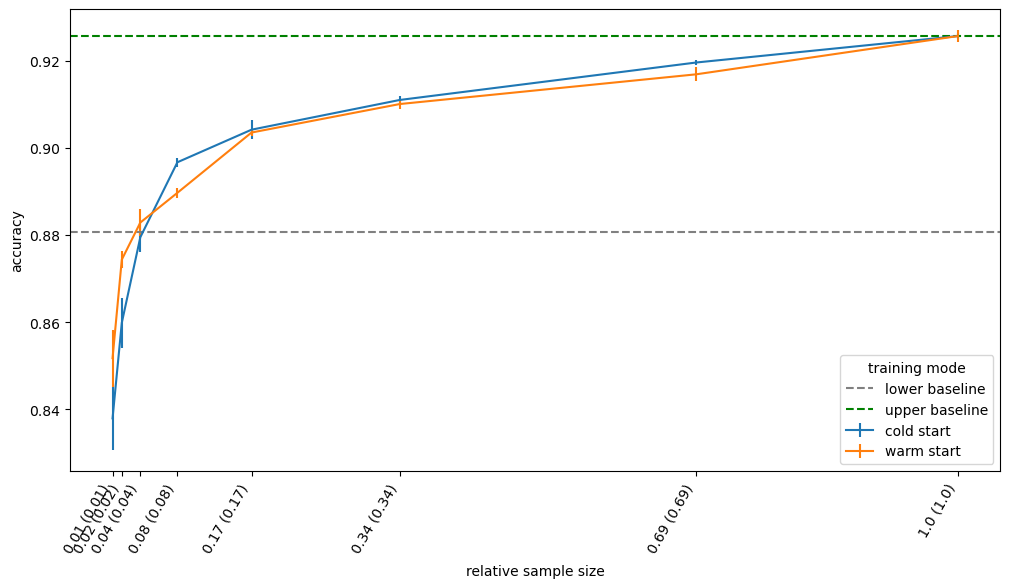

In [64]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.errorbar(al_perf_acc_pd['relative_size'], al_perf_acc_pd['acc_coldstart'], al_perf_acc_pd['se_coldstart'])
ax.errorbar(al_perf_acc_pd['relative_size'], al_perf_acc_pd['acc_warmstart'], al_perf_acc_pd['se_warmstart'])
ax.set_xlabel('relative sample size')
ax.set_xticks(al_perf_acc_pd['relative_size'])
ax.set_xticklabels(
    [
        f' {round(i, 2)} ({round(j, 2)})' 
        for i, j in zip(al_perf_acc_pd['relative_size'], al_perf_acc_pd['relative_size'])
    ],
    rotation=60,
    ha='right'
)
ax.set_ylabel('accuracy')
# ax2 = ax.twiny()
# ax2.set_xticks(al_perf_acc_pd['relative_size'])
# ax2.set_xticklabels(batch_sizes, rotation=45)
# ax2.set_xlabel('absolute sample size')
# ax.set_xscale('log')
ax.axhline(acc_al_lower_limit,color='gray',ls='--')
ax.axhline(acc_al_upper_limit,color='green',ls='--')
ax.legend(
    title='training mode', 
    loc='lower right', 
    labels=['lower baseline', 'upper baseline', 'cold start', 'warm start']
)
plt.savefig('active_learning.eps')